#### CSC 215 Artificial Intelligence (Spring 2023)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 14:  Three APIs to build TF Models: Sequential vs Functional vs Subclassed

### Want to be a deep learning beginner or an expert?  

### I recommend you running this lab in Google Colab

In [ ]:
import os 
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Sequential Model:
In simple, Sequential model consists of Keras layers linearly stacked in the model. This is simple and serves ~60–70% of the applications but has a major limitation that it works only with single-input and single-output. If your use case requires multiple inputs and/or outputs, then go for Functional or Subclassed model APIs.

### CNN-sequential (for beginner)

In [ ]:
input_shape = (50,50,1)
batch_size = 32
learning_rate = 0.0001


dropout_rate = 0.4
num_classes=3
num_epochs=30

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10
)

In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential()


# Feature Extraction
model.add(tf.keras.Input(shape=input_shape)) #Input 
model.add(layers.Conv2D(16, (3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(16, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))

#Classification
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(num_classes, activation="softmax"))


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
hist = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

### CNN-sequential (for expert)

### GradientTape is a brand-new function in TensorFlow 2.0

One of the largest criticisms of the TensorFlow 1.x low-level API, as well as the Keras high-level API, was that it made it very challenging for deep learning researchers to write custom training loops that could:

1. Customize the data batching process
2. Handle multiple inputs and/or outputs with different spatial dimensions
3. Utilize a custom loss function
4. Access gradients for specific layers and update them in a unique manner

#### With the TensorFlow 2.0 release, we now have the GradientTape function, which makes it easier than ever to write custom training loops for both TensorFlow and Keras models, thanks to automatic differentiation.

In [ ]:
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images)   # define the forward pass
        
        #print(predictions.shape)
        #print(labels.shape)
        
        loss = loss_object(labels, predictions)    # compute the loss
    gradients = tape.gradient(loss, model.trainable_variables)    # compute the gradient
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))   # apply the gradient
    train_loss(loss)
    train_accuracy(labels, predictions)
    
    
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(32)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [ ]:
class EarlyStopping:
    def __init__(self):
        self.test_acc_list = []
        self.length = 10
        
    def step(self, acc):
        self.test_acc_list.append(acc.numpy())
        if len(self.test_acc_list) > self.length:
            self.test_acc_list.pop(0)
    def is_stop(self, epoch):
        mean = sum(self.test_acc_list)/len(self.test_acc_list)
        recent_acc = self.test_acc_list[-1]
        if epoch > 10:
            
            if recent_acc - mean <=0.01:
                print("Early Stopping!")
                print("recent_acc: {}, mean acc: {} ".format(recent_acc, mean) )
                return True
            
        return False

In [ ]:
es = EarlyStopping()

EPOCHS = 30

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)
    
    template = "Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}"
    print(template.format(
  
        epoch+1,
        train_loss.result(),
        train_accuracy.result() * 100,
        test_loss.result(),
        test_accuracy.result() * 100
    ))
    
    
    es.step(test_accuracy.result())
    if es.is_stop(epoch):
        break
        
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    

Sample run:

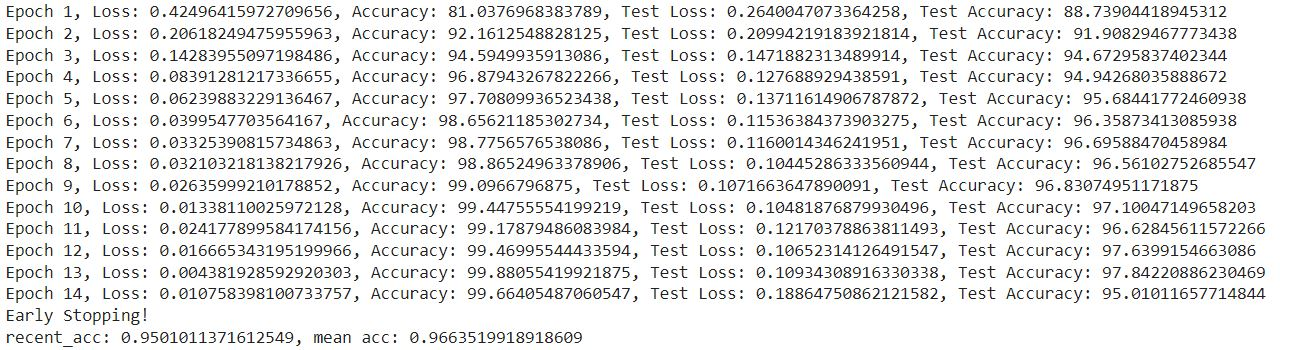

# Functional Model:
Functional model handles multiple-inputs and outputs. This model API can be used for developing complex models that can serve most of the use cases.

### CNN-functional (for beginner)

In [ ]:
input_shape = (50,50,1)
batch_size = 32
learning_rate = 0.0001

dropout_rate = 0.4
num_classes=3
num_epochs=50

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10
)

In [ ]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inputs)
net = layers.Conv2D(16, (3,3), padding="same", activation="relu")(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Conv2D(32, (3,3), padding="same", activation="relu")(net)
net = layers.Conv2D(32, (3,3), padding="same", activation="relu")(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Conv2D(64, (3,3), padding="same", activation="relu")(net)
net = layers.Conv2D(64, (3,3), padding="same", activation="relu")(net)

net = layers.Flatten()(net)
net = layers.Dense(128)(net)
net = layers.Activation("relu")(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)

net = layers.Activation("softmax")(net)


model = tf.keras.Model(inputs=inputs, outputs=net, name="NN")

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
hist = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping] # decay option
)

### CNN-functional (for expert)

In [ ]:
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images)
        
        #print(predictions.shape)
        #print(labels.shape)
        
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    
    
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(32)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [ ]:
class EarlyStopping:
    def __init__(self):
        self.test_acc_list = []
        self.length = 10
        
    def step(self, acc):
        self.test_acc_list.append(acc.numpy())
        if len(self.test_acc_list) > self.length:
            self.test_acc_list.pop(0)
    def is_stop(self, epoch):
        mean = sum(self.test_acc_list)/len(self.test_acc_list)
        recent_acc = self.test_acc_list[-1]
        if epoch > 20:
            
            if recent_acc - mean <=0.005:
                print("Early Stopping!")
                print("recent_acc: {}, mean acc: {} ".format(recent_acc, mean) )
                return True
            
        return False

In [ ]:
es = EarlyStopping()

EPOCHS = 30

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)
    
    template = "Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}"
    print(template.format(
  
        epoch+1,
        train_loss.result(),
        train_accuracy.result() * 100,
        test_loss.result(),
        test_accuracy.result() * 100
    ))
    
    
    es.step(test_accuracy.result())
    if es.is_stop(epoch):
        break
        
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    

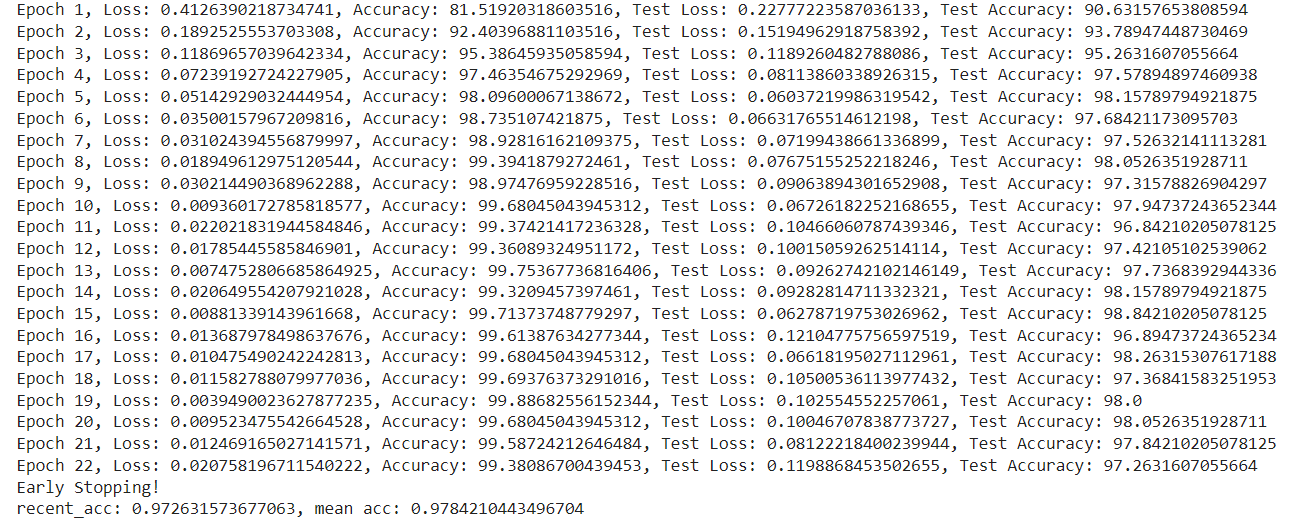

# Subclassed Model:
This is most complex when compared to the above two model APIs but provides **most flexibility while modeling complex use cases**. 

**Here, your define your model as a subclass of Keras Model class (tf.keras.Model) to inherit functionality under the class, such as fit/predict/eval etc**.

One major difference between the Subclassed model and the above two model APIs is that 

 **the former is a piece of python code in the call method whereas the latter is a static graph.** 

Because of this difference, saving and loading Subclassed models is significantly different from other model APIs.

### CNN-subclassed (for beginner)

##### In sub-classing API, there are two most important functions __ __init__ __ and **call**. Basically, we will 
1. define all the tf.keras layers or custom implemented layers inside the __
__init__ __ method and 
2. call those layers based on our network design inside the **call** method,  which defines the forward pass (propagation) of the model. 

The **call** method is exactly the same as the **forward** method used in PyTorch.

In [ ]:
input_shape = (50,50,1)
batch_size = 32

learning_rate = 0.0001

dropout_rate = 0.4
num_classes=3
num_epochs=100

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10
)

In [ ]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()
        conv2d = tf.keras.layers.Conv2D
        maxpool = tf.keras.layers.MaxPool2D
        self.sequence = list()
        self.sequence.append(conv2d(16, (3,3), padding="same", activation='relu' ))
        self.sequence.append(conv2d(16, (3,3), padding="same", activation='relu' ))
        self.sequence.append(maxpool(2,2))
        self.sequence.append(conv2d(32, (3,3), padding="same", activation='relu' ))
        self.sequence.append(conv2d(32, (3,3), padding="same", activation='relu' ))
        self.sequence.append(maxpool(2,2))
        self.sequence.append(conv2d(64, (3,3), padding="same", activation='relu' ))
        self.sequence.append(conv2d(64, (3,3), padding="same", activation='relu' ))
        self.sequence.append(tf.keras.layers.Flatten())
        self.sequence.append(tf.keras.layers.Dense(128, activation="relu"))
        self.sequence.append(tf.keras.layers.Dense(3, activation="softmax"))
        
        
        
    def call(self, x, training=False, mask=None):
        for layer in self.sequence:
            x = layer(x)
        
        return x

In [ ]:
model = ConvNet()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
hist = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

### CNN-subclassed (for expert)

In [ ]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()
        conv2d = tf.keras.layers.Conv2D
        maxpool = tf.keras.layers.MaxPool2D
        self.sequence = list()
        self.sequence.append(conv2d(16, (3,3), padding="same", activation='relu' ))
        self.sequence.append(conv2d(16, (3,3), padding="same", activation='relu' ))
        self.sequence.append(maxpool(2,2))
        self.sequence.append(conv2d(32, (3,3), padding="same", activation='relu' ))
        self.sequence.append(conv2d(32, (3,3), padding="same", activation='relu' ))
        self.sequence.append(maxpool(2,2))
        self.sequence.append(conv2d(64, (3,3), padding="same", activation='relu' ))
        self.sequence.append(conv2d(64, (3,3), padding="same", activation='relu' ))
        self.sequence.append(tf.keras.layers.Flatten())
        self.sequence.append(tf.keras.layers.Dense(128, activation="relu"))
        self.sequence.append(tf.keras.layers.Dense(3, activation="softmax"))
        
        
        
    def call(self, x, training=False, mask=None):
        for layer in self.sequence:
            x = layer(x)
        
        return x

In [ ]:
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images)
        
        #print(predictions.shape)
        #print(labels.shape)
        
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    
    
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(32)

In [ ]:
model = ConvNet()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [ ]:
class EarlyStopping:
    def __init__(self):
        self.test_acc_list = []
        self.length = 10
        
    def step(self, acc):
        self.test_acc_list.append(acc.numpy())
        if len(self.test_acc_list) > self.length:
            self.test_acc_list.pop(0)
    def is_stop(self, epoch):
        mean = sum(self.test_acc_list)/len(self.test_acc_list)
        recent_acc = self.test_acc_list[-1]
        if epoch > 10:
            
            if recent_acc - mean <=0.01:
                print("Early Stopping!")
                print("recent_acc: {}, mean acc: {} ".format(recent_acc, mean) )
                return True
            
        return False

In [ ]:
es = EarlyStopping()

EPOCHS = 30

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)
    
    template = "Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}"
    print(template.format(
  
        epoch+1,
        train_loss.result(),
        train_accuracy.result() * 100,
        test_loss.result(),
        test_accuracy.result() * 100
    ))
    
    
    es.step(test_accuracy.result())
    if es.is_stop(epoch):
        break
        
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    
    

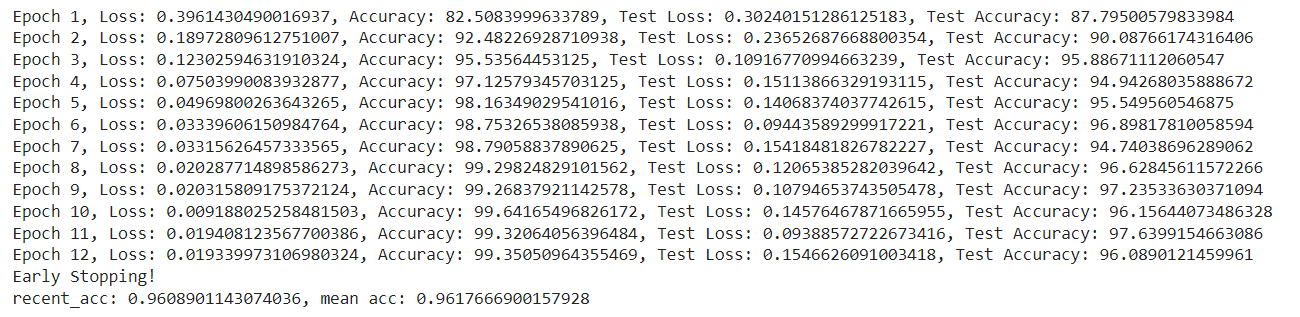

# Reflection: When to use functional API and when to use subclassing API?


**The power of the Sequentail API: allows you to quickly define an one-input one-output model (model as static graph)**

**The power of the Functional API: allows you to fully control the layer connectivity (model as static graph)**

**The power of the Subclassing API: allows you to implement everything from scratch (debug your model the same as python code)**.


# Demo   (a smart course classifier to make study plan)

Input:  [title, catalog_text_body, tags], 

outputs:  [units, department]

**Let's create this asa multiple input and multiple output model**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

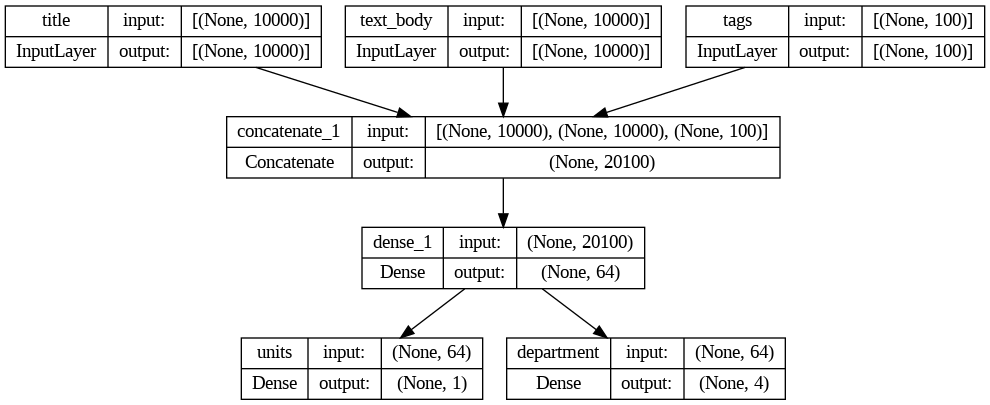

In [7]:

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Concatenate

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed


vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = Input(shape=(vocabulary_size,), name="title")
text_body = Input(shape=(vocabulary_size,), name="text_body")
tags = Input(shape=(num_tags,), name="tags")

features = Concatenate()([title, text_body, tags])
features = Dense(64, activation="relu")(features)

units = Dense(1, name="units")(features)
department = Dense(
    num_departments, activation="softmax", name="department")(features)

model = Model(inputs=[title, text_body, tags], outputs=[units, department])

# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

**Training this multi-input, multi-output model by providing lists of sample input & target arrays**

In [8]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

units_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data],
          [units_data, department_data],
          epochs=10)

model.evaluate([title_data, text_body_data, tags_data],
               [units_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

Epoch 1/10
40/40 [==============================] - 2s 21ms/step - loss: 350.0547 - units_loss: 342.6480 - department_loss: 7.4067 - units_mean_absolute_error: 4.3434 - department_accuracy: 0.5266
Epoch 2/10
40/40 [==============================] - 1s 20ms/step - loss: 12.1687 - units_loss: 8.5994 - department_loss: 3.5693 - units_mean_absolute_error: 2.0621 - department_accuracy: 0.3867
Epoch 3/10
40/40 [==============================] - 1s 20ms/step - loss: 12.7149 - units_loss: 9.3937 - department_loss: 3.3212 - units_mean_absolute_error: 3.0150 - department_accuracy: 0.2945
Epoch 4/10
40/40 [==============================] - 1s 19ms/step - loss: 13.6277 - units_loss: 10.1585 - department_loss: 3.4692 - units_mean_absolute_error: 3.1239 - department_accuracy: 0.2469
Epoch 5/10
40/40 [==============================] - 1s 29ms/step - loss: 15.1929 - units_loss: 11.3963 - department_loss: 3.7967 - units_mean_absolute_error: 3.2966 - department_accuracy: 0.2891
Epoch 6/10
40/40 [=======

**Functional API allows you to retrieve the inputs or outputs of any layer in a Functional model**

In [9]:
model.layers

In [4]:
model.layers[3]

In [10]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [11]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate_1')>

**You can also create a new model by reusing intermediate layer outputs**

We want to predict course difficulty as well

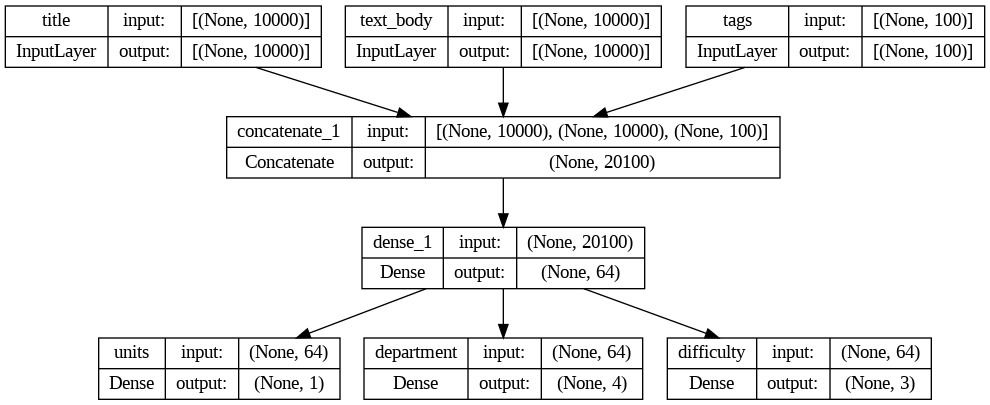

In [12]:
features = model.layers[4].output
difficulty = Dense(3, activation="softmax", name="difficulty")(features)

new_model = Model(
    inputs=[title, text_body, tags],
    outputs=[units, department, difficulty])

plot_model(new_model, show_shapes=True)

### Let's rewrite this model as a subclassed model

In [13]:
class CustomerCourseModel(Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = Concatenate()
        self.mixing_layer = Dense(64, activation="relu")
        self.units_scorer = Dense(1)
        self.department_classifier = Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        units = self.units_scorer(features)
        department = self.department_classifier(features)
        return units, department

In [16]:
model = CustomerCourseModel(num_departments=4)

units, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})      # this is your model input

In [18]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [units_data, department_data],
          epochs=10)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [units_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})




Epoch 1/10
40/40 [==============================] - 3s 21ms/step - loss: 16.0814 - output_1_loss: 1.5409 - output_2_loss: 14.5405 - output_1_mean_absolute_error: 1.0230 - output_2_accuracy: 0.1336
Epoch 2/10
40/40 [==============================] - 1s 20ms/step - loss: 9.7921 - output_1_loss: 1.6558 - output_2_loss: 8.1363 - output_1_mean_absolute_error: 1.1614 - output_2_accuracy: 0.1937
Epoch 3/10
40/40 [==============================] - 1s 19ms/step - loss: 6.4933 - output_1_loss: 2.1836 - output_2_loss: 4.3097 - output_1_mean_absolute_error: 1.1291 - output_2_accuracy: 0.2906
Epoch 4/10
40/40 [==============================] - 1s 19ms/step - loss: 7.4133 - output_1_loss: 2.7444 - output_2_loss: 4.6689 - output_1_mean_absolute_error: 1.4828 - output_2_accuracy: 0.2758
Epoch 5/10
40/40 [==============================] - 1s 19ms/step - loss: 8.8838 - output_1_loss: 4.0108 - output_2_loss: 4.8730 - output_1_mean_absolute_error: 1.9389 - output_2_accuracy: 0.3102
Epoch 6/10
40/40 [=====

**Defference between call() (i.e., model()) and predict()**

A general rule: Use call() (i.e., model()) on one batch while use model.predict(x) on multiple batches

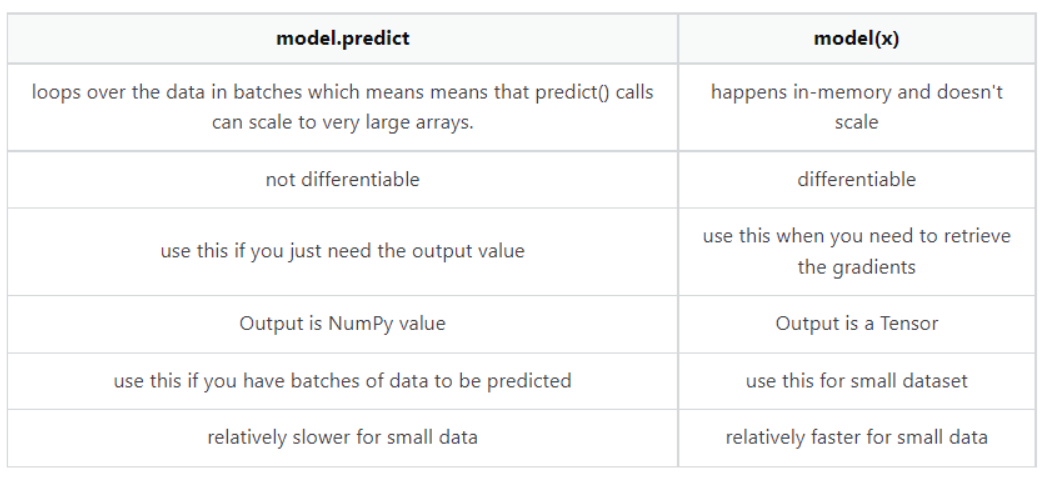

### Remember: Use the right tool for your job